In [1]:
import numpy as np
from urllib.request import urlopen
import scipy.optimize
import random
from sklearn import svm
from sklearn import linear_model
import matplotlib.pyplot as plt 

In [2]:
def parseDataFromURL(fname):
    for l in urlopen(fname):
        yield eval(l)

def parseData(fname):
    for l in open(fname):
        yield eval(l)

In [3]:
print("Reading data...")
# Download from http://jmcauley.ucsd.edu/cse258/data/amazon/book_descriptions_50000.json
data = list(parseData("data/fantasy_10000.json"))
print("done")

Reading data...
done


**Regression**

Distribution  of  ratings  and  review  lengths  in  the  dataset:


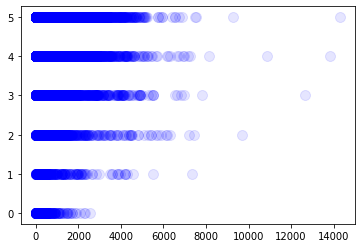

0-star reviews: 326
1-star reviews: 286
2-star reviews: 778
3-star reviews: 2113
4-star reviews: 3265
5-star reviews: 3232


In [4]:
print("Distribution  of  ratings  and  review  lengths  in  the  dataset:")

rating_sum = [0]*6
x = []
y = []
for d in data:
    y.append(d['rating'])
    x.append(len(d['review_text']))
    rating_sum[d['rating']] += 1

plt.scatter(x, y, c ="blue", alpha=0.1, s=100) 
plt.show()
for i, d in enumerate(rating_sum):
    print("{}-star reviews: {}".format(i,d))

In [5]:
print("Simple predictor that estimates rating from review length:")
def feature(datum):
    feat = [1, len(datum['review_text'])]
    return feat

X = [feature(d) for d in data]
y = [d['rating'] for d in data]
theta,residuals,rank,s = np.linalg.lstsq(X, y)
mse = sum((y - np.dot(X, theta))**2) / len(y)

print("Star Rating =~ {} + {} x [review length in characters]".format(theta[0], theta[1]))
print("θ0 = {}".format(theta[0]))
print("θ1 = {}".format(theta[1]))
print("MSE = {}".format(mse))

Simple predictor that estimates rating from review length:
Star Rating =~ 3.68568135501692 + 6.873716748962714e-05 x [review length in characters]
θ0 = 3.68568135501692
θ1 = 6.873716748962714e-05
MSE = 1.552208662235533


C:\Users\SD-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


In [6]:
print("Re-training predictor so as to include a second feature based on the number of comments:")
def feature(datum):
    feat = [1, len(datum['review_text']), datum['n_comments']]
    return feat

X = [feature(d) for d in data]
y = [d['rating'] for d in data]
theta,residuals,rank,s = np.linalg.lstsq(X, y)
mse = sum((y - np.dot(X, theta))**2) / len(y)

print("Star Rating =~ {} + {} x [review length in characters] + {} x [number of comments]".format(theta[0], theta[1], theta[2]))
print("θ0 = {}".format(theta[0]))
print("θ1 = {}".format(theta[1]))
print("θ2 = {}".format(theta[2]))
print("MSE = {}".format(mse))

print("θ1 is different this time, because we trained our predictor also on the feature of # of comments in addition to review length.")

Re-training predictor so as to include a second feature based on the number of comments:
Star Rating =~ 3.689167374290103 + 7.584074903973424e-05 x [review length in characters] + -0.03279289354454787 x [number of comments]
θ0 = 3.689167374290103
θ1 = 7.584074903973424e-05
θ2 = -0.03279289354454787
MSE = 1.549835169277462
θ1 is different this time, because we trained our predictor also on the feature of # of comments in addition to review length.


C:\Users\SD-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


In [7]:
print("Model that fits a polynomial function to estimate ratings based on review length:")
def feature(datum, p, maxlen):
    feat = [1]
    for i in range(1, p+1):
        feat.append((len(datum['review_text'])/maxlen)**i)
    return feat

#Normalizing data:
maxlen = max([len(d['review_text']) for d in data])

for i in range(1, 6):
    X = [feature(d, i, maxlen) for d in data]
    y = [d['rating'] for d in data]
    theta,residuals,rank,s = np.linalg.lstsq(X, y)
    mse = sum((y - np.dot(X, theta))**2) / len(y)
    print("Degree {}:".format(i))
    print("MSE = {}".format(mse))
    #print("Thetas:", theta)
    print()

Model that fits a polynomial function to estimate ratings based on review length:
Degree 1:
MSE = 1.5522086622355333

Degree 2:
MSE = 1.5506567696339402

Degree 3:
MSE = 1.549798532380552

Degree 4:

C:\Users\SD-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  



MSE = 1.5496291324524685

Degree 5:
MSE = 1.5496142023298658



In [8]:
print("Split the data into a training and test set:")
def feature(datum, p, maxlen):
    feat = [1]
    for i in range(1, p+1):
        feat.append((len(datum['review_text'])/maxlen)**i)
    return feat

#Splitting data:
temp = data
random.shuffle(temp)
train_data = temp[:len(temp)//2]
test_data = temp[len(temp)//2:]

#Normalizing data:
train_maxlen = max([len(d['review_text']) for d in train_data])
test_maxlen = max([len(d['review_text']) for d in test_data])

for i in range(1, 6):
    train_X = [feature(d, i, train_maxlen) for d in train_data]
    train_y = [d['rating'] for d in train_data]
    test_X = [feature(d, i, test_maxlen) for d in test_data]
    test_y = [d['rating'] for d in test_data]
    
    theta,residuals,rank,s = np.linalg.lstsq(train_X, train_y)
    train_mse = sum((train_y - np.dot(train_X, theta))**2) / len(train_y)
    
    test_mse = sum((test_y - np.dot(test_X, theta))**2) / len(test_y)
    print("Degree {}:".format(i))
    print("Train MSE = {}".format(train_mse))
    print("Test MSE = {}".format(test_mse))
    #print("Thetas:", theta)
    print()

C:\Users\SD-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Split the data into a training and test set:
Degree 1:
Train MSE = 1.5896633963799565
Test MSE = 1.5160721103073511

Degree 2:
Train MSE = 1.5881356266932174
Test MSE = 1.5143755692238003

Degree 3:
Train MSE = 1.5881328812938094
Test MSE = 1.5141975748144305

Degree 4:
Train MSE = 1.5880518165234623
Test MSE = 1.5141643190895937

Degree 5:
Train MSE = 1.5880454776929163
Test MSE = 1.5141471843061511



**Classification**

In [9]:
print("Reading data...")
# Download from http://jmcauley.ucsd.edu/cse258/data/amazon/book_descriptions_50000.json
data = []
data2 = list(parseData("data/beer_50000.json"))
for l in data2:
    if 'user/gender' in l:
        data.append(l)
print("done")

Reading data...
done


In [10]:
print("Logistic regressor that estimates gender from review length:")
def feature(datum):
    feat = [len(datum['review/text'])]
    return feat

X = [feature(d) for d in data]
y = [0 if d['user/gender']=='Male' else 1 for d in data]

mod = linear_model.LogisticRegression(C=1.0)
mod.fit(X, y)

pred = mod.predict(X)
correct = pred == y

# True positives, false positives, etc.
TP_ = np.logical_and(pred, y)
FP_ = np.logical_and(pred, np.logical_not(y))
TN_ = np.logical_and(np.logical_not(pred), np.logical_not(y))
FN_ = np.logical_and(np.logical_not(pred), y)

TP = sum(TP_)
FP = sum(FP_)
TN = sum(TN_)
FN = sum(FN_)

TPR = TP / (TP+FN)
TNR = TN / (TN+FP)
FPR = FP / (FP+TN)
FNR = FN / (TP+FN)

BER = 1 - 0.5 * (TP / (TP + FN) + TN / (TN + FP))

print("TP rate: {}".format(TPR))
print("FP rate: {}".format(FPR))
print("TN rate: {}".format(TNR))
print("FN rate: {}".format(FNR))
print("BER: {}".format(BER))

Logistic regressor that estimates gender from review length:


C:\Users\SD-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


TP rate: 0.0
FP rate: 0.0
TN rate: 1.0
FN rate: 1.0
BER: 0.5


In [11]:
print("Retraining the regressor using the class_weight=’balanced’ option:")
def feature(datum):
    feat = [len(datum['review/text'])]
    return feat

X = [feature(d) for d in data]
y = [0 if d['user/gender']=='Male' else 1 for d in data]

mod = linear_model.LogisticRegression(C=1.0, class_weight='balanced')
mod.fit(X, y)

pred = mod.predict(X)
correct = pred == y

# True positives, false positives, etc.
TP_ = np.logical_and(pred, y)
FP_ = np.logical_and(pred, np.logical_not(y))
TN_ = np.logical_and(np.logical_not(pred), np.logical_not(y))
FN_ = np.logical_and(np.logical_not(pred), y)

TP = sum(TP_)/len(y)
FP = sum(FP_)/len(y)
TN = sum(TN_)/len(y)
FN = sum(FN_)/len(y)
TPR = TP / (TP+FN)
TNR = TN / (TN+FP)
FPR = FP / (FP+TN)
FNR = FN / (TP+FN)

BER = 1 - 0.5 * (TP / (TP + FN) + TN / (TN + FP))

print("TP rate: {}".format(TPR))
print("FP rate: {}".format(FPR))
print("TN rate: {}".format(TNR))
print("FN rate: {}".format(FNR))
print("BER: {}".format(BER))

Retraining the regressor using the class_weight=’balanced’ option:


C:\Users\SD-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


TP rate: 0.6461038961038961
FP rate: 0.5795969146553869
TN rate: 0.42040308534461307
FN rate: 0.3538961038961039
BER: 0.46674650927574546


In [12]:
print("Incorporating additional features from the data:")
def feature(datum):
    feat = [len(datum['review/text']), datum['review/appearance'], datum['review/palate'],datum['review/taste'],datum['review/overall'],datum['review/aroma'], datum['beer/ABV']]
    return feat

X = np.array([feature(d) for d in data])
X = X / X.max(axis=0)
y = [0 if d['user/gender']=='Male' else 1 for d in data]

mod = linear_model.LogisticRegression(C=1.0, class_weight='balanced')
mod.fit(X, y)

pred = mod.predict(X)
correct = pred == y

# True positives, false positives, etc.
TP_ = np.logical_and(pred, y)
FP_ = np.logical_and(pred, np.logical_not(y))
TN_ = np.logical_and(np.logical_not(pred), np.logical_not(y))
FN_ = np.logical_and(np.logical_not(pred), y)

TP = sum(TP_)/len(y)
FP = sum(FP_)/len(y)
TN = sum(TN_)/len(y)
FN = sum(FN_)/len(y)
TPR = TP / (TP+FN)
TNR = TN / (TN+FP)
FPR = FP / (FP+TN)
FNR = FN / (TP+FN)

BER = 1 - 0.5 * (TP / (TP + FN) + TN / (TN + FP))

print("TP rate: {}".format(TPR))
print("FP rate: {}".format(FPR))
print("TN rate: {}".format(TNR))
print("FN rate: {}".format(FNR))
print("BER: {}".format(BER))

Incorporating additional features from the data:


C:\Users\SD-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


TP rate: 0.5844155844155844
FP rate: 0.5057476984324459
TN rate: 0.4942523015675542
FN rate: 0.41558441558441556
BER: 0.46066605700843066
